<h1>Forecasting Test 1<h1>

1. Converting dataframe dates to months only.
2. Will be testing LSTM vs ARIMA model performance using RMSE.
3. Predict 6 months using the best model.
4. Comparing with actual data to check accuracy of predict.

<h4>Data Cleaning<h4>

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import KFold
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

df = pd.read_csv('.\Datasets\CR_COST_FC_new.csv', converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})
df['POD'] = pd.to_datetime(df['POD'])
df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
df = df.dropna(subset=['ENCODED_TYPE'])
df['RATE'] = df['RATE'].fillna(-1).astype(int)
df = df.dropna(subset=['RATE'])
df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)

# Remove NAN values
df_clean= df.dropna().reset_index(drop=True)

df_clean.head()
df_clean.info()
print(f'Dataset size: {df_clean.shape}')

,COM_ID,PARTY_ID,PARTY_ID_EN,PARTY_NAME,CSL_ID,ETA_ETD_NO,ETD_POL_D,POD_ID,POD,CNTR_ID,CNTR_SIZE,CNTR_TYPE,COST_TERM,RATE,ENCODED_TYPE,ENCODED_TERM,POD_ID_EN
0,010,010003678,10003678,OY TAVATUR SHIPPING LTD,ECS010060100191,20060228,FIHEL,HELSINKI,2006-02-28,CTNR010060201232,20,GP,FC,675,2,1,4.103561e+09
1,010,010004286,10004286,"GLOBELINK KOREA CO., LTD",ECS010060100465,20060303,KRPUS,BUSAN,2006-03-03,CTNR010060300014,40,HC,FC,390,1,1,2.904902e+09
2,010,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,ECS010060100321,20060227,NZAKL,AUCKLAND,2006-02-27,CTNR010060201198,40,HC NOR,FC,1615,4,1,2.397848e+09
3,010,01002775,1002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,ECS010060200201,20060306,AUADL,ADELAIDE,2006-03-06,CTNR010060300119,40,HC,FC,700,1,1,2.480737e+08
4,010,01001088,1001088,CARGO LINES S.A.-LE HAVRE,ECS010060200146,20060307,FRMRS,MARSEILLE,2006-03-07,CTNR010060300185,20,GP,FC,675,2,1,4.197227e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54722 entries, 0 to 54721
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        54722 non-null  object        
 1   PARTY_ID      54722 non-null  object        
 2   PARTY_ID_EN   54722 non-null  int64         
 3   PARTY_NAME    54722 non-null  object        
 4   CSL_ID        54722 non-null  object        
 5   ETA_ETD_NO    54722 non-null  int64         
 6   ETD_POL_D     54722 non-null  object        
 7   POD_ID        54722 non-null  object        
 8   POD           54722 non-null  datetime64[ns]
 9   CNTR_ID       54722 non-null  object        
 10  CNTR_SIZE     54722 non-null  object        
 11  CNTR_TYPE     54722 non-null  object        
 12  COST_TERM     54722 non-null  object        
 13  RATE          54722 non-null  int32         
 14  ENCODED_TYPE  54722 non-null  int32         
 15  ENCODED_TERM  54722 non-null  int64 

In [54]:
sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
           'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']

df_fc = df_clean[sel_col]
df_fc.head()
df_fc.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010060100191,CTNR010060201232,HELSINKI,FIHEL,010003678,OY TAVATUR SHIPPING LTD,2006-02-28,20,GP,675
1,ECS010060100465,CTNR010060300014,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2006-03-03,40,HC,390
2,ECS010060100321,CTNR010060201198,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2006-02-27,40,HC NOR,1615
3,ECS010060200201,CTNR010060300119,ADELAIDE,AUADL,01002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,2006-03-06,40,HC,700
4,ECS010060200146,CTNR010060300185,MARSEILLE,FRMRS,01001088,CARGO LINES S.A.-LE HAVRE,2006-03-07,20,GP,675


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54722 entries, 0 to 54721
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      54722 non-null  object        
 1   CNTR_ID     54722 non-null  object        
 2   POD_ID      54722 non-null  object        
 3   ETD_POL_D   54722 non-null  object        
 4   PARTY_ID    54722 non-null  object        
 5   PARTY_NAME  54722 non-null  object        
 6   POD         54722 non-null  datetime64[ns]
 7   CNTR_SIZE   54722 non-null  object        
 8   CNTR_TYPE   54722 non-null  object        
 9   RATE        54722 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 4.0+ MB


In [55]:
# filter out rows where the year is 2002
df_filtered = df_fc[df_fc['POD'].dt.year != 2002]
df_filtered.head()
df_filtered.info()

# Checking if year 2002 is removed
df_filtered['POD'].dt.year.unique()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010060100191,CTNR010060201232,HELSINKI,FIHEL,010003678,OY TAVATUR SHIPPING LTD,2006-02-28,20,GP,675
1,ECS010060100465,CTNR010060300014,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2006-03-03,40,HC,390
2,ECS010060100321,CTNR010060201198,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2006-02-27,40,HC NOR,1615
3,ECS010060200201,CTNR010060300119,ADELAIDE,AUADL,01002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,2006-03-06,40,HC,700
4,ECS010060200146,CTNR010060300185,MARSEILLE,FRMRS,01001088,CARGO LINES S.A.-LE HAVRE,2006-03-07,20,GP,675


<class 'pandas.core.frame.DataFrame'>
Int64Index: 54721 entries, 0 to 54721
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      54721 non-null  object        
 1   CNTR_ID     54721 non-null  object        
 2   POD_ID      54721 non-null  object        
 3   ETD_POL_D   54721 non-null  object        
 4   PARTY_ID    54721 non-null  object        
 5   PARTY_NAME  54721 non-null  object        
 6   POD         54721 non-null  datetime64[ns]
 7   CNTR_SIZE   54721 non-null  object        
 8   CNTR_TYPE   54721 non-null  object        
 9   RATE        54721 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 4.4+ MB


array([2006, 2005, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2018, 2019, 2020, 2021, 2016, 2017, 2022, 2023], dtype=int64)

In [56]:
# Sorting the dates 
df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
df_filtered.head()
df_filtered.tail()
df_filtered['POD'].dt.year.unique()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
54716,ECS010230400526,010000573399,VALPARAISO,CLVAP,010006350,CRAFT MULTIMODAL CHILE SPA,2023-05-24,40,HC,1300
54717,ECS010230400525,010000582631,CALLAO,PECLL,010026711,CRAFT MULTIMODAL PERU S.A,2023-05-24,40,HC NOR,1300
54718,ECS010230400452,010000580585,BUENOS AIRES,ARBUE,010006300,CRAFT ARGENTINA SA,2023-05-25,40,HC,2300
54719,ECS010230400451,010000554136,MONTEVIDEO,UYMVD,010021385,CRAFT URUGUAY CHEBURIN S.A,2023-05-25,40,HC,1100
54720,ECS010230400352,010000588769,ASHDOD,ILASH,010008035,MAYAN OVERSEAS LTD,2023-05-27,20,GP,2100


array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], dtype=int64)

<h4>FIltering and getting a list stored as a dictionary</h4>

In [57]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [58]:
filtered_dataframes = filter_dataframe(df_filtered)

# Show case some samples of keys
df_ids = list(filtered_dataframes.keys())
print(list(df_ids))
print(len(list(df_ids)))

['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100028193', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_Party

<h4>Getting the top 5 ports</h4>

In [59]:
# Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
key_row_counts = {key: len(filtered_dataframes[key]) for key in filtered_dataframes}

# Sort the key_row_counts dictionary by value (number of rows) in descending order
sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)
# print(sorted_key_row_counts)

# Get the top 5 keys with the most rows
top_5_keys_tuple = sorted_key_row_counts[:5]
# print(top_5_keys_tuple)

# Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
filtered_dataframes_subset = {}

for key, row_count in top_5_keys_tuple:
    filtered_dataframes_subset[key] = filtered_dataframes[key][:5]
    print(f"Number of rows in {key}: {row_count}")

# print(filtered_dataframes_subset.keys())

Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


In [60]:
# Selected dataframe
sel_df = filtered_dataframes['Port_BUSAN_Size_40_Type_HC_PartyID_010004286']
sel_df.head()
sel_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390
1,ECS010050800407,CTNR010050901379,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390
2,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390
3,ECS010050900468,CTNR010050901461,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390
4,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1712 entries, 0 to 1711
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1712 non-null   object        
 1   CNTR_ID     1712 non-null   object        
 2   POD_ID      1712 non-null   object        
 3   ETD_POL_D   1712 non-null   object        
 4   PARTY_ID    1712 non-null   object        
 5   PARTY_NAME  1712 non-null   object        
 6   POD         1712 non-null   datetime64[ns]
 7   CNTR_SIZE   1712 non-null   object        
 8   CNTR_TYPE   1712 non-null   object        
 9   RATE        1712 non-null   int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 140.4+ KB


In [61]:
# Check for duplicates and keep only one instance of each unique combination
sel_df = sel_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)
sel_df.info()
sel_df.head(15)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139 entries, 0 to 1138
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1139 non-null   object        
 1   CNTR_ID     1139 non-null   object        
 2   POD_ID      1139 non-null   object        
 3   ETD_POL_D   1139 non-null   object        
 4   PARTY_ID    1139 non-null   object        
 5   PARTY_NAME  1139 non-null   object        
 6   POD         1139 non-null   datetime64[ns]
 7   CNTR_SIZE   1139 non-null   object        
 8   CNTR_TYPE   1139 non-null   object        
 9   RATE        1139 non-null   int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 84.7+ KB


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390
1,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390
2,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390
3,ECS010050900471,CTNR010051001330,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-30,40,HC,390
4,ECS010051000380,CTNR010051001332,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-11-03,40,HC,390
5,ECS010051000381,CTNR010051100185,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-11-12,40,HC,390
6,ECS010051000382,CTNR010051101339,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-11-28,40,HC,390
7,ECS010051100223,CTNR010051101279,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-12-04,40,HC,390
8,ECS010051100224,CTNR010051200319,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-12-10,40,HC,390
9,ECS010051100227,CTNR010051201287,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-12-31,40,HC,390


In [62]:
# Initialize the reference date with the first date in the "POD" column
reference_date = sel_df['POD'].iloc[0]

# Calculate the difference in days and print it out
for index, date in enumerate(sel_df['POD']):
    if index > 0:
        prev_date = sel_df['POD'].iloc[index - 1]
        days_difference = (date - prev_date).days
        print(f"Difference between {prev_date}and {date}: {days_difference} days")

Difference between 2005-10-03 00:00:00and 2005-10-07 00:00:00: 4 days
Difference between 2005-10-07 00:00:00and 2005-10-14 00:00:00: 7 days
Difference between 2005-10-14 00:00:00and 2005-10-30 00:00:00: 16 days
Difference between 2005-10-30 00:00:00and 2005-11-03 00:00:00: 4 days
Difference between 2005-11-03 00:00:00and 2005-11-12 00:00:00: 9 days
Difference between 2005-11-12 00:00:00and 2005-11-28 00:00:00: 16 days
Difference between 2005-11-28 00:00:00and 2005-12-04 00:00:00: 6 days
Difference between 2005-12-04 00:00:00and 2005-12-10 00:00:00: 6 days
Difference between 2005-12-10 00:00:00and 2005-12-31 00:00:00: 21 days
Difference between 2005-12-31 00:00:00and 2006-01-07 00:00:00: 7 days
Difference between 2006-01-07 00:00:00and 2006-02-04 00:00:00: 28 days
Difference between 2006-02-04 00:00:00and 2006-02-10 00:00:00: 6 days
Difference between 2006-02-10 00:00:00and 2006-02-17 00:00:00: 7 days
Difference between 2006-02-17 00:00:00and 2006-02-24 00:00:00: 7 days
Difference betwe

In [63]:
# Formating by month
# Create new dataframe for aggregated results
agg_df = pd.DataFrame(columns=['YearMonth', 'Year', 'Month', 'Rate'])

# Group by Year and Month
grouped = sel_df.groupby([sel_df['POD'].dt.year, sel_df['POD'].dt.month])

for group_name, group_df in grouped:
    year, month = group_name
    
    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()
    
    # Calculate mean or median based on skewness
    if rate_skew < 0:
        rate_metric = group_df['RATE'].mean()
    else:
        rate_metric = group_df['RATE'].median()
    
    new_row = {
        'YearMonth': pd.Timestamp(year=year, month=month, day=1),
        'Year': year,
        'Month': month,
        'Rate': rate_metric
    }
    
    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)
    
agg_df['YearMonth_en'] = agg_df["YearMonth"].dt.strftime('%Y%m%d').astype(int)

agg_df.head(10)
agg_df.info()

C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_25356\947613913.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_25356\947613913.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_25356\947613913.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_25356\947613913.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df 

,YearMonth,Year,Month,Rate,YearMonth_en
0,2005-10-01,2005,10,390.0,20051001
1,2005-11-01,2005,11,390.0,20051101
2,2005-12-01,2005,12,390.0,20051201
3,2006-01-01,2006,1,390.0,20060101
4,2006-02-01,2006,2,390.0,20060201
5,2006-03-01,2006,3,385.0,20060301
6,2006-04-01,2006,4,380.0,20060401
7,2006-05-01,2006,5,380.0,20060501
8,2006-08-01,2006,8,380.0,20060801
9,2006-09-01,2006,9,380.0,20060901


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   YearMonth     185 non-null    datetime64[ns]
 1   Year          185 non-null    object        
 2   Month         185 non-null    object        
 3   Rate          185 non-null    float64       
 4   YearMonth_en  185 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(2)
memory usage: 6.6+ KB


<h4>Plotting with new and old data to see how much different</h4>

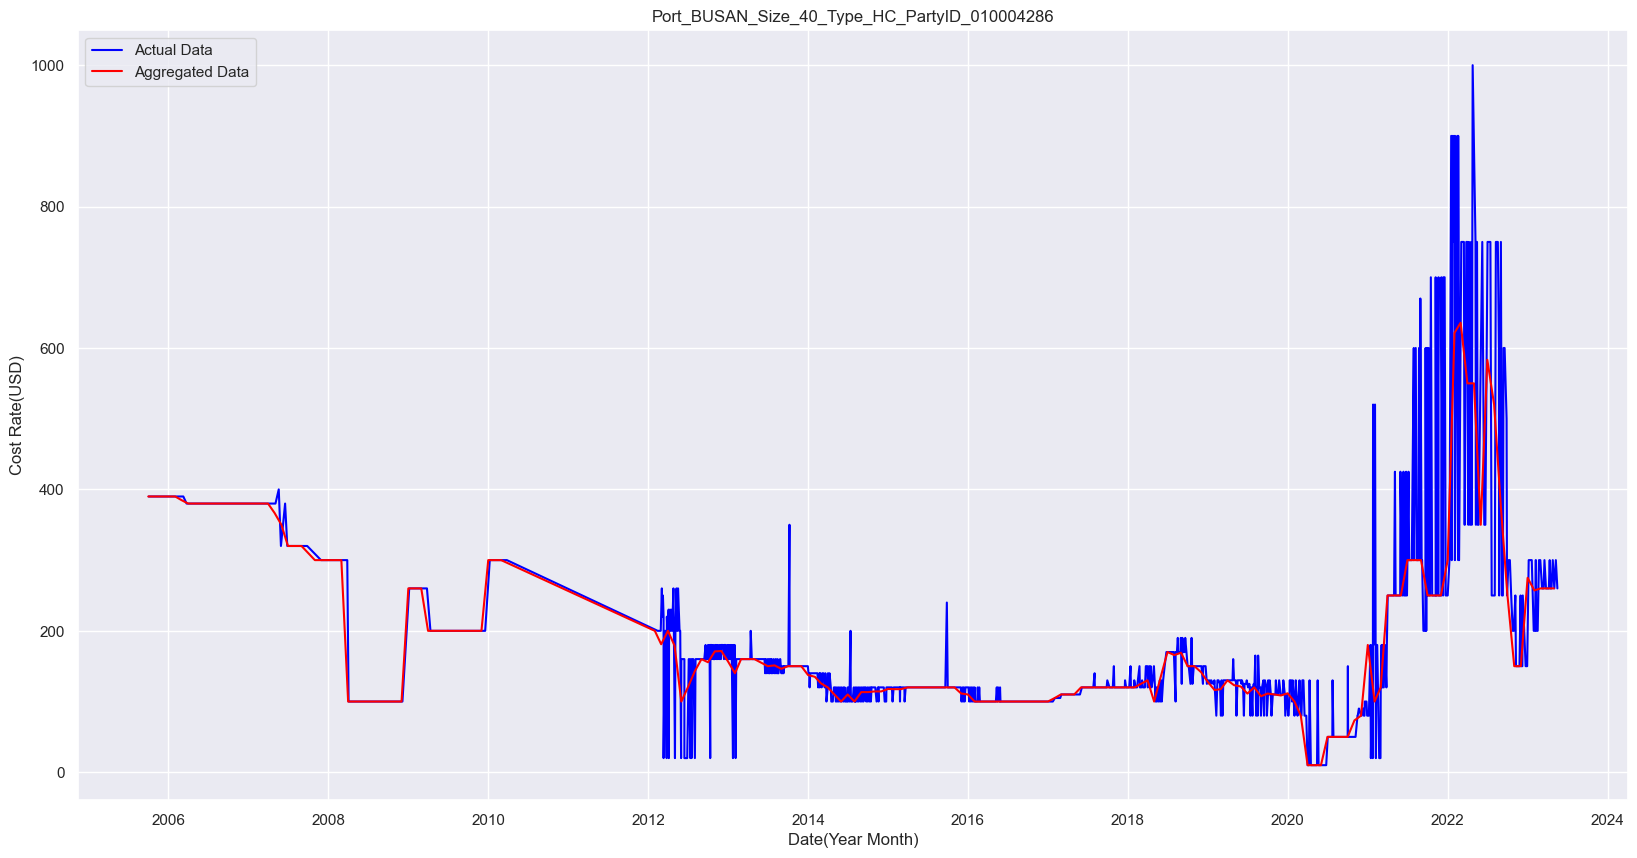

In [64]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(agg_df['YearMonth'], agg_df['Rate'], color='red', label="Aggregated Data")

plt.xlabel('Date(Year Month)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();

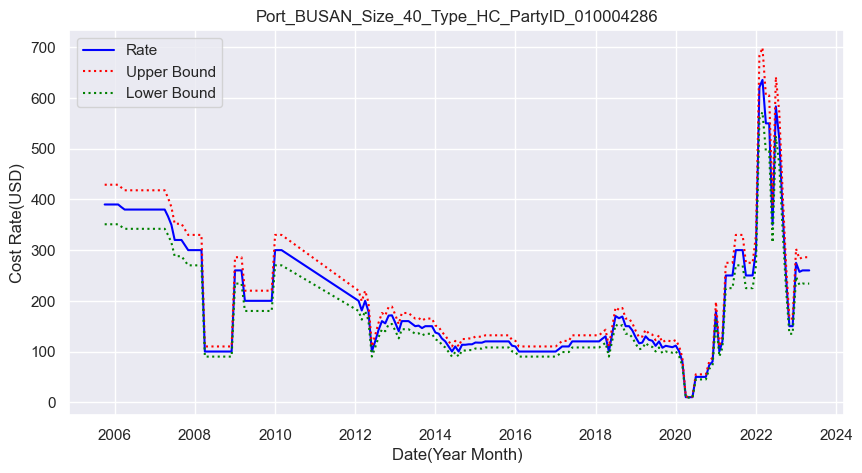

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(agg_df['YearMonth'], agg_df['Rate'], color='blue', label='Rate')

# Calculate upper and lower bounds for aggr value for "Rate"
upper_bound = agg_df['Rate'] * 1.10
lower_bound = agg_df['Rate'] * 0.90

# Plot upper and lower bounds as dotted lines
plt.plot(agg_df['YearMonth'], upper_bound, linestyle='dotted', color='red', label='Upper Bound')
plt.plot(agg_df['YearMonth'], lower_bound, linestyle='dotted', color='green', label='Lower Bound')

plt.xlabel('Date(Year Month)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();


<h4>Mean Square Error Evaluation Function</h4>

In [66]:
# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

<h4>Plot Prediction Function to see model fitting</h4>

In [67]:
def plot_predictions_v1(df, trainPredict, testPredict, look_back):
    
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(df)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(df)
    testPredictPlot[:, :] = np.nan
    print(f'testPredict shape: {testPredict.shape}')
    print(f'testPredictPlot section shape: {testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :].shape}')
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :1] = testPredict

    # plot baseline and predictions
    plt.figure(figsize=(15,8))
    plt.plot(scaler.inverse_transform(df), color='blue', label='Actual Data')
    plt.plot(trainPredictPlot, color='orange', label='Training Fit')
    plt.plot(testPredictPlot, color='green', label='Testing Prediction')
    plt.legend(loc='upper left')
    plt.show()

In [68]:
def plot_predictions_v2(df, trainPredict, testPredict, look_back):
    # Shift train predictions for plotting
    trainPredictPlot = np.empty_like(df)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :1] = trainPredict

    # Shift test predictions for plotting
    testPredictPlot = np.empty_like(df)
    testPredictPlot[:, :] = np.nan
    print(f'testPredict shape: {testPredict.shape}')
    print(f'testPredictPlot section shape: {testPredictPlot[len(trainPredict)+look_back:len(df), :].shape}')
    testPredictPlot[len(trainPredict)+(look_back*2):len(df), :1] = testPredict

    # plot baseline and predictions
    plt.figure(figsize=(15,8))
    plt.plot(scaler.inverse_transform(df['Rate'].values.reshape(-1,1)), color='blue', label='Actual Data')
    plt.plot(trainPredictPlot, color='orange', label='Training Fit')
    plt.plot(testPredictPlot, color='green', label='Testing Prediction')
    plt.legend(loc='upper left')
    plt.show()


<h4>LSTM Regression<h4>

In [69]:
# Dataframe for LSTM
df_lstm1 = agg_df[['YearMonth','Rate']]
df_lstm1.head()
df_lstm1.info()

,YearMonth,Rate
0,2005-10-01,390.0
1,2005-11-01,390.0
2,2005-12-01,390.0
3,2006-01-01,390.0
4,2006-02-01,390.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   YearMonth  185 non-null    datetime64[ns]
 1   Rate       185 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB


In [70]:
# Restructure time series data for LSTM model
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [71]:
def create_LSTM_model(trainX, trainY):
    # LSTM model
    model = Sequential()
    model.add(LSTM(4, input_shape=(trainX.shape[1], trainX.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit the model
    model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)
    return model


Epoch 1/50
127/127 - 1s - loss: 0.0738 - 1s/epoch - 11ms/step
Epoch 2/50
127/127 - 0s - loss: 0.0328 - 147ms/epoch - 1ms/step
Epoch 3/50
127/127 - 0s - loss: 0.0221 - 142ms/epoch - 1ms/step
Epoch 4/50
127/127 - 0s - loss: 0.0199 - 143ms/epoch - 1ms/step
Epoch 5/50
127/127 - 0s - loss: 0.0186 - 147ms/epoch - 1ms/step
Epoch 6/50
127/127 - 0s - loss: 0.0172 - 141ms/epoch - 1ms/step
Epoch 7/50
127/127 - 0s - loss: 0.0159 - 144ms/epoch - 1ms/step
Epoch 8/50
127/127 - 0s - loss: 0.0144 - 141ms/epoch - 1ms/step
Epoch 9/50
127/127 - 0s - loss: 0.0130 - 143ms/epoch - 1ms/step
Epoch 10/50
127/127 - 0s - loss: 0.0117 - 144ms/epoch - 1ms/step
Epoch 11/50
127/127 - 0s - loss: 0.0098 - 149ms/epoch - 1ms/step
Epoch 12/50
127/127 - 0s - loss: 0.0081 - 165ms/epoch - 1ms/step
Epoch 13/50
127/127 - 0s - loss: 0.0063 - 154ms/epoch - 1ms/step
Epoch 14/50
127/127 - 0s - loss: 0.0047 - 156ms/epoch - 1ms/step
Epoch 15/50
127/127 - 0s - loss: 0.0034 - 143ms/epoch - 1ms/step
Epoch 16/50
127/127 - 0s - loss: 0.0

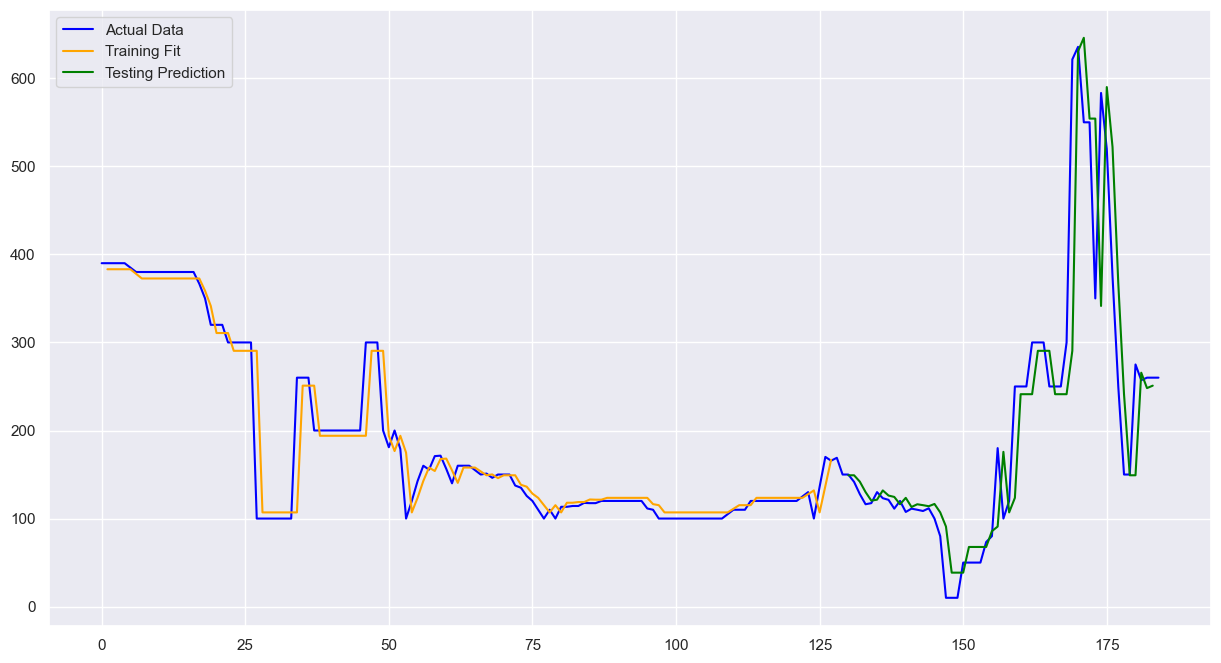

In [72]:
# Normalize dataset for LSTM
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_lstm1['Rate'].values.reshape(-1,1))

# Split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape into X=t and Y=t+1, timestep  look_back
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Store the model
model = create_LSTM_model(trainX, trainY)

# Evalute LSTM Model
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions back to prescaled values
# This is to compare with original input
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate mean squared error
trainScore = calculate_RMSE(trainY[0], trainPredict[:,0])
print('Train Score: %.2f RMSE' % (trainScore))
testScore = calculate_RMSE(testY[0], testPredict[:,0])
print('Test Score: %.2f RMSE' % (testScore))

# View how LSTM model fitting to the actual data
plot_predictions_v1(dataset, trainPredict, testPredict, look_back)

From the above RMSE value is it still consider large. It still could be the abrupt changes during covid season from 2020 - 2022 can be difficult for LSTM regression Model as it might be confused as predictions is based on historical data and there is a suddent change in these patterns. Therefore, the model might be "confused".

Will be trying to incorporate external features into my model to indicate covid-19 presence and indicate using binary variable for rates.
1. 0 is for pre-covid
2. 1 is for post-covid 

This is to help the model to better understand the impact of Covid-19. Tried anomaly detection. However, there isnt enough data to train the anomaly detection.

<h4>Testing LSTM Regression model with external features</h4>

In [73]:
def create_dataset_v2(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

,YearMonth,Rate,Covid
0,2005-10-01,390.0,0
1,2005-11-01,390.0,0
2,2005-12-01,390.0,0
3,2006-01-01,390.0,0
4,2006-02-01,390.0,0


,YearMonth,Rate,Covid
180,2023-01-01,275.000000,1
181,2023-02-01,257.142857,0
182,2023-03-01,260.000000,0
183,2023-04-01,260.000000,0
184,2023-05-01,260.000000,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   YearMonth  185 non-null    datetime64[ns]
 1   Rate       185 non-null    float64       
 2   Covid      185 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 4.5 KB
Epoch 1/50
128/128 - 1s - loss: 0.0707 - 1s/epoch - 11ms/step
Epoch 2/50
128/128 - 0s - loss: 0.0287 - 146ms/epoch - 1ms/step
Epoch 3/50
128/128 - 0s - loss: 0.0215 - 146ms/epoch - 1ms/step
Epoch 4/50
128/128 - 0s - loss: 0.0196 - 143ms/epoch - 1ms/step
Epoch 5/50
128/128 - 0s - loss: 0.0180 - 145ms/epoch - 1ms/step
Epoch 6/50
128/128 - 0s - loss: 0.0164 - 182ms/epoch - 1ms/step
Epoch 7/50
128/128 - 0s - loss: 0.0149 - 147ms/epoch - 1ms/step
Epoch 8/50
128/128 - 0s - loss: 0.0132 - 146ms/epoch - 1ms/step
Epoch 9/50
128/128 - 0s - loss: 0.0118 - 147ms/epoch - 1ms/step
Epoch 10/50
128/12

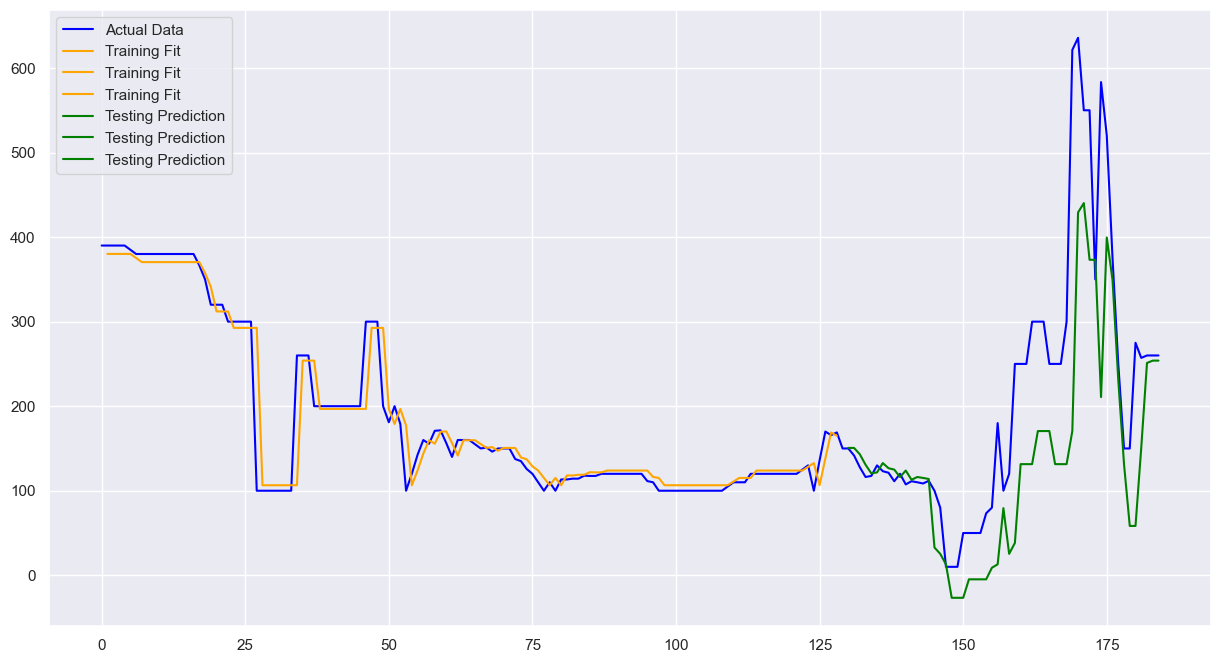

In [74]:
# Dataframe for LSTM2
df_lstm2 = agg_df[['YearMonth','Rate']].copy()

# Create a new column indicating whether each month is affected by COVID-19
df_lstm2['Covid'] = 0
df_lstm2.loc[(df_lstm2['YearMonth'] >= '2020-01') & (df_lstm2['YearMonth'] <= '2023-01'), 'Covid'] = 1

df_lstm2.head()
df_lstm2.tail()
df_lstm2.info()

# Fit a separate scaler for 'Rate'
scaler_rate = MinMaxScaler(feature_range=(0, 1))
df_lstm2['Rate'] = scaler_rate.fit_transform(df_lstm2['Rate'].values.reshape(-1,1))

# Split into train and test sets
train_size = int(len(df_lstm2) * 0.7)
test_size = len(df_lstm2) - train_size
train, test = df_lstm2.iloc[0:train_size,:], df_lstm2.iloc[train_size:len(df_lstm2),:]

# Prepare data for LSTM
look_back = 1
trainX, trainY = create_dataset_v2(train['Rate'].values, look_back)
testX, testY = create_dataset_v2(test['Rate'].values, look_back)

# Add Covid column to the features
trainX = np.hstack((trainX, train['Covid'][:-look_back].values.reshape(-1,1)))
testX = np.hstack((testX, test['Covid'][:-look_back].values.reshape(-1,1)))

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Run LSTM model
model = create_LSTM_model(trainX, trainY)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler_rate.inverse_transform(trainPredict)
trainY = scaler_rate.inverse_transform(trainY.reshape(-1,1))
testPredict = scaler_rate.inverse_transform(testPredict)
testY = scaler_rate.inverse_transform(testY.reshape(-1,1))

# Calculate mean squared error
trainScore = calculate_RMSE(trainY, trainPredict)
print('Train Score: %.2f RMSE' % (trainScore))
testScore = calculate_RMSE(testY, testPredict)
print('Test Score: %.2f RMSE' % (testScore))

# Plot predictions
plot_predictions_v2(df_lstm2, trainPredict, testPredict, look_back)


<h4>Modeling For ARIMA<h4>

In [75]:
# Dataframe for ARIMA For Log Transform
df_arima1 = agg_df[['YearMonth','Rate']].copy()
df_arima1.set_index('YearMonth', inplace=True)
df_arima1.head()
df_arima1.info()

# Dataframe for ARIMA 
df_arima2 = agg_df[['YearMonth','Rate']].copy()
df_arima2.set_index('YearMonth', inplace=True)
df_arima2.head()
df_arima2.info()

,Rate
YearMonth,
2005-10-01,390.0
2005-11-01,390.0
2005-12-01,390.0
2006-01-01,390.0
2006-02-01,390.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 185 entries, 2005-10-01 to 2023-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rate    185 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


,Rate
YearMonth,
2005-10-01,390.0
2005-11-01,390.0
2005-12-01,390.0
2006-01-01,390.0
2006-02-01,390.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 185 entries, 2005-10-01 to 2023-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rate    185 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=58.226, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=54.317, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56.228, Time=0.03 sec


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=56.226, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52.329, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.261 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  185
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -25.164
Date:                Thu, 15 Jun 2023   AIC                             52.329
Time:                        17:44:20   BIC                             55.544
Sample:                             0   HQIC                            53.632
                                - 185                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma

C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_25356\1561968310.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1['Rate'] = np.exp(train1['Rate'])
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_25356\1561968310.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['Rate'] = np.exp(test1['Rate'])


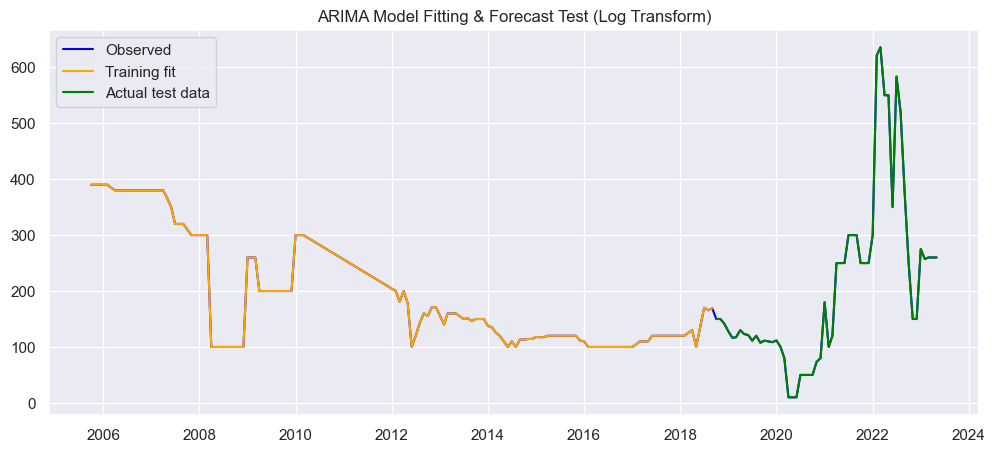

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_squared_error

# Apply logarithm transformation to 'Rate' column
df_arima1['Rate'] = np.log(df_arima1['Rate'])

# Fit an auto_arima model
arima_model1 = pm.auto_arima(df_arima1['Rate'], start_p=1, start_q=1, 
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=False, 
                            d=1, D=1, trace=True,
                            error_action='ignore',  # don't want to know if an order does not work
                            suppress_warnings=True,  # don't want convergence warnings
                            stepwise=True)  # set to stepwise

# Print the summary of the model
print(arima_model1.summary())

# Split the data into training and test data
train_size1 = int(len(df_arima1) * 0.7)
train1, test1 = df_arima1[0:train_size1], df_arima1[train_size1:]

# Train the model on the training data
arima_model1.fit(train['Rate'])

# Forecast
train_forecast1, conf_int_train1 = arima_model1.predict(n_periods=len(train1), return_conf_int=True)
test_forecast1, conf_int_test1 = arima_model1.predict(n_periods=len(test1), return_conf_int=True)

# Reverse the logarithm transformation
train1['Rate'] = np.exp(train1['Rate'])
test1['Rate'] = np.exp(test1['Rate'])
train_forecast1 = np.exp(train_forecast1)
test_forecast1 = np.exp(test_forecast1)
conf_int_train1 = np.exp(conf_int_train1)
conf_int_test1 = np.exp(conf_int_test1)

# Calculate the RMSE
RMSE_ARIMA_train1 = np.sqrt(mean_squared_error(train1['Rate'], train_forecast1))
print("Train RMSE: %.3f" % RMSE_ARIMA_train1)
RMSE_ARIMA_test1 = np.sqrt(mean_squared_error(test1['Rate'], test_forecast1))
print("Test RMSE: %.3f" % RMSE_ARIMA_test1)

# Plot the predictions
plt.figure(figsize=(12,5))
plt.plot(df_arima1.index, np.exp(df_arima1['Rate']), label='Observed',color='blue')
plt.plot(df_arima1.index[:train_size], train1['Rate'], label='Training fit', color='orange')
plt.plot(df_arima1.index[train_size:], test1['Rate'], label='Actual test data', color='green')
# plt.fill_between(df_arima1.index[train_size1:], conf_int_test1[:, 0], conf_int_test1[:, 1], 
#                  color='k', alpha=.25)
plt.title('ARIMA Model Fitting & Forecast Test (Log Transform)')
plt.legend()
plt.show();


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1242.360, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1749.655, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1606.739, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1240.373, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1240.903, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1240.247, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1244.188, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1239.075, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1242.982, Time=0.11 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1238.314, Time=0.29 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=1236.961, Time=0.31 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=1241.5

c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


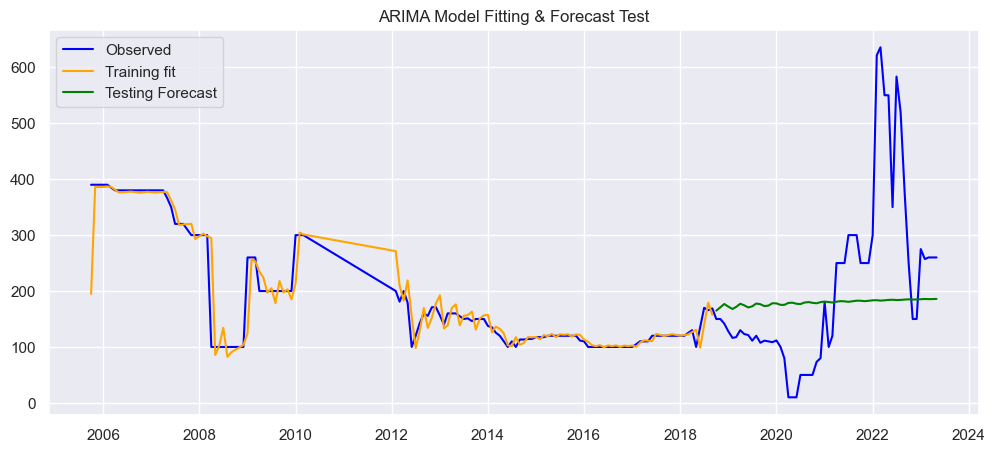

In [79]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error

# Split the data into training and test data
train_size2 = int(len(df_arima2) * 0.7)
train2, test2 = df_arima2[0:train_size2], df_arima2[train_size2:]

# Fit an auto_arima model
arima_model2 = pm.auto_arima(train2['Rate'], start_p=1, start_q=1, 
                            max_p=12, max_q=12, m=12,
                            start_P=0, seasonal=False, 
                            d=0, D=0, trace=True,
                            error_action='ignore', 
                            suppress_warnings=True, 
                            stepwise=True)  # set to stepwise

# Print the summary of the model
print(arima_model2.summary())

# Forecast
train_forecast2 = arima_model2.predict_in_sample()
test_forecast2 = arima_model2.predict(n_periods=len(test2))

# Calculate the RMSE
RMSE_ARIMA_train2 = np.sqrt(mean_squared_error(train2['Rate'], train_forecast2))
print("Train RMSE: %.3f" % RMSE_ARIMA_train2)
RMSE_ARIMA_test2 = np.sqrt(mean_squared_error(test2['Rate'], test_forecast2))
print("Test RMSE: %.3f" % RMSE_ARIMA_test2)

# Plot the predictions
plt.figure(figsize=(12,5))
plt.plot(df_arima2.index, df_arima2['Rate'], label='Observed',color='blue')
plt.plot(df_arima2.index[:train_size2], train_forecast2, label='Training fit', color='orange')
plt.plot(df_arima2.index[train_size2:], test_forecast2, label='Testing Forecast', color='green')
plt.title('ARIMA Model Fitting & Forecast Test')
plt.legend()
plt.show();
